In [74]:
from testing_environments import ContinuousTMaze, GridEnvRightDownNoCue, GridEnvRightDownNoSelf, GridEnvDivergingMultipleReward, GridEnvDivergingSingleReward
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
class SarsaAgent:
    def __init__(self, 
                 n_states,          # total number of states (including terminal states)
                 max_actions,       # maximum possible actions (e.g., 2 for right/down)
                 alpha=0.1,         # learning rate
                 gamma=0.99,        # discount factor
                 epsilon=0.1,       # epsilon for epsilon-greedy
                 seed=None):
        """
        n_states     : integer, number of possible states in the environment 
                       (including terminal labels).
        max_actions  : integer, maximum # of discrete actions. Even if some states 
                       have fewer valid actions, we define the Q array for 
                       [n_states x max_actions] for convenience.
        alpha        : learning rate (0 < alpha <= 1).
        gamma        : discount factor (0 < gamma <= 1).
        epsilon      : exploration probability for epsilon-greedy policy.
        seed         : optional random seed for reproducibility.
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.n_states = n_states
        self.max_actions = max_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Initialize Q(s,a) for all states, actions to 0.0
        # We'll store Q in a 2D numpy array [state, action].
        # For states that do not allow certain actions, you can still keep them in
        # the array, but you must only update/choose among valid actions.
        self.Q = np.zeros((n_states+1, max_actions), dtype=float)
        # +1 or not depends on how you've indexed states. If your environment states
        # go from 1..(n_states), you might want an array of shape [n_states+1, max_actions]
        # so that Q[state, action] is accessible.
        # Adjust indexing as needed.
        
    def choose_action(self, state, valid_actions):
        """
        Epsilon-greedy action selection among valid actions only.
        """
        # If no valid actions, return None (terminal states).
        if len(valid_actions) == 0:
            return None
        
        # Epsilon-greedy
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            # Greedy among valid actions
            q_values = [self.Q[state, a] for a in valid_actions]
            max_q = max(q_values)
            # To break ties randomly, gather all actions that match max_q
            candidates = [a for a in valid_actions if self.Q[state, a] == max_q]
            return random.choice(candidates)

    def update(self, state, action, reward, next_state, next_action):
        """
        SARSA update:
          Q(s,a) ← Q(s,a) + α [ R + γ Q(s',a') - Q(s,a) ]
        If next_action is None (i.e. terminal), we treat Q(s',a')=0.
        """
        current_q = self.Q[state, action]
        if next_action is not None:
            next_q = self.Q[next_state, next_action]
        else:
            next_q = 0.0  # Terminal
        
        # SARSA update
        target = reward + self.gamma * next_q
        self.Q[state, action] = current_q + self.alpha * (target - current_q)

    def run_episode(self, env):
        """
        Runs a single episode using SARSA.
        Returns the total reward obtained in this episode.
        """
        # Reset environment
        state = env.reset()
        
        # Choose initial action
        valid_actions = env.get_valid_actions(state)
        action = self.choose_action(state, valid_actions)
        
        total_reward = 0
        done = False
        
        while not done:
            # Take the chosen action in the environment
            if action is None:
                # If no valid action, we are effectively done
                break
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            # If not done, choose next action
            if not done:
                next_valid_actions = env.get_valid_actions(next_state)
                next_action = self.choose_action(next_state, next_valid_actions)
            else:
                next_action = None

            # Update Q
            self.update(state, action, reward, next_state, next_action)
            
            # Move on
            state = next_state
            action = next_action
        
        return total_reward

    def train(self, env, n_episodes=1000, verbose=False):
        """
        Train the SARSA agent for n_episodes on the given environment.
        Returns a list of episode rewards for analysis.
        """
        rewards_history = []
        for episode in range(n_episodes):
            ep_reward = self.run_episode(env)
            rewards_history.append(ep_reward)
            if verbose and (episode+1) % 100 == 0:
                print(f"Episode {episode+1}/{n_episodes}, Reward: {ep_reward}")
        return rewards_history


class SarsaLambdaAgent:
    def __init__(self, 
                 n_states,         # total number of states (including any terminal labels)
                 max_actions,      # number of possible actions
                 alpha=0.1,        # learning rate
                 gamma=0.99,       # discount factor
                 lam=0.9,          # lambda parameter for eligibility traces
                 epsilon=0.1,      # epsilon for epsilon-greedy
                 replacing_traces=True,
                 seed=None):
        """
        A tabular SARSA(λ) agent.

        n_states      : total number of environment states (1..n_states).
        max_actions   : number of discrete actions (0..max_actions-1).
        alpha         : learning rate.
        gamma         : discount factor.
        lam           : lambda parameter for eligibility traces.
        epsilon       : exploration rate.
        replacing_traces : if True, use 'replacing traces' (E(s,a)=1 on visiting),
                           else use 'accumulating traces' (E(s,a) += 1).
        seed          : optional random seed for reproducibility.
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.n_states = n_states
        self.max_actions = max_actions
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        self.replacing_traces = replacing_traces

        # Q-table: shape [n_states+1, max_actions],
        # because states might be labeled 1..n_states.
        self.Q = np.zeros((n_states+1, max_actions), dtype=float)

    def choose_action(self, state, valid_actions):
        """Epsilon-greedy action selection among valid actions."""
        if len(valid_actions) == 0:
            return None  # No valid actions (terminal)
        
        # Epsilon-greedy
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            # Greedy among valid actions
            q_values = [self.Q[state, a] for a in valid_actions]
            max_q = max(q_values)
            # Potential tie-breaking among actions that share max Q
            candidates = [a for a in valid_actions if self.Q[state, a] == max_q]
            return random.choice(candidates)

    def run_episode(self, env):
        """Run one episode using SARSA(λ). Returns total reward."""
        # 1) Reset environment
        state = env.reset()
        
        # 2) Initialize eligibility traces to zero
        E = np.zeros_like(self.Q)

        # 3) Choose initial action
        valid_actions = env.get_valid_actions(state)
        action = self.choose_action(state, valid_actions)

        total_reward = 0
        done = False

        while not done:
            if action is None:
                # If no valid action, we're done
                break

            # Take action, observe next_state, reward
            next_state, reward, done = env.step(action)
            total_reward += reward

            # If not done, choose next action
            if not done:
                next_valid_actions = env.get_valid_actions(next_state)
                next_action = self.choose_action(next_state, next_valid_actions)
            else:
                next_action = None

            # SARSA TD-error
            current_q = self.Q[state, action]
            if next_action is not None:
                future_q = self.Q[next_state, next_action]
            else:
                future_q = 0.0  # Terminal

            delta = reward + self.gamma * future_q - current_q

            # Update eligibility trace
            if self.replacing_traces:
                # Replacing traces
                E[state, action] = 1.0
            else:
                # Accumulating traces
                E[state, action] += 1.0

            # Update Q for all s,a
            self.Q += self.alpha * delta * E

            # Decay eligibility traces
            E *= self.gamma * self.lam

            # Move on
            state = next_state
            action = next_action
        
        return total_reward

    def train(self, env, n_episodes=500, verbose=False):
        """Train the agent for n_episodes. Returns a list of episode rewards."""
        rewards_history = []
        for episode in range(n_episodes):
            ep_reward = self.run_episode(env)
            rewards_history.append(ep_reward)
            if verbose and (episode+1) % 100 == 0:
                print(f"Episode {episode+1}/{n_episodes}, Reward: {ep_reward}")
        return rewards_history
import numpy as np
import random
from collections import deque, defaultdict

class NthOrderSarsaAgent:
    def __init__(self,
                 n,                # The 'order' (how many past states we include)
                 max_actions,      # Number of possible actions (0..max_actions-1)
                 alpha=0.1,        # Learning rate
                 gamma=0.99,       # Discount factor
                 epsilon=0.1,      # Epsilon for epsilon-greedy
                 seed=None):
        """
        A tabular nth-order SARSA agent. States are n-tuples of the last n env states.

        Parameters
        ----------
        n : int
            The 'order'. We'll track the last n environment states as the 'meta-state'.
        max_actions : int
            Total number of discrete actions in the environment.
        alpha : float
            Learning rate.
        gamma : float
            Discount factor.
        epsilon : float
            Exploration probability for epsilon-greedy.
        seed : int or None
            Optional random seed for reproducibility.
        """
        self.n = n
        self.max_actions = max_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Q dictionary: keys = (state_tuple, action), value = float Q-value
        #   where state_tuple is an n-tuple of env states
        # We'll default to 0.0 for unseen state-action pairs.
        self.Q = defaultdict(float)

    def _get_q_value(self, state_tuple, action):
        """
        Fetch Q(state_tuple, action). Returns 0.0 if not in dictionary.
        """
        return self.Q[(state_tuple, action)]

    def _set_q_value(self, state_tuple, action, value):
        """
        Set Q(state_tuple, action) = value in dictionary.
        """
        self.Q[(state_tuple, action)] = value

    def choose_action(self, state_tuple, valid_actions):
        """
        Epsilon-greedy action selection among valid actions, 
        given the nth-order meta-state (state_tuple).
        """
        if len(valid_actions) == 0:
            return None  # no valid actions (terminal)

        # Epsilon-greedy
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            # Greedy among valid actions
            q_vals = [self._get_q_value(state_tuple, a) for a in valid_actions]
            max_q = max(q_vals)
            # tie-break among actions with Q == max_q
            candidates = [a for a in valid_actions 
                          if self._get_q_value(state_tuple, a) == max_q]
            return random.choice(candidates)

    def run_episode(self, env):
        """
        Runs a single episode using nth-order SARSA.
        Returns total reward obtained in this episode.
        """
        # Reset environment
        first_state = env.reset()
        total_reward = 0
        done = False

        # We'll keep a buffer of the last n states. Initialize with [first_state].
        # For the first few steps (t < n-1), we'll just replicate that state,
        # or you could use a special 'null' state. Here we keep it simple.
        state_buffer = deque([first_state] * self.n, maxlen=self.n)

        # Current nth-order state (as a tuple)
        current_tuple = tuple(state_buffer)
        valid_actions = env.get_valid_actions(first_state)
        action = self.choose_action(current_tuple, valid_actions)

        while not done:
            if action is None:
                # If no valid action, we're effectively in a terminal condition
                break

            # Take step in environment
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Update state buffer
            state_buffer.append(next_state)
            next_tuple = tuple(state_buffer)

            # If not done, choose next action from next_tuple
            if not done:
                next_valid_actions = env.get_valid_actions(next_state)
                next_action = self.choose_action(next_tuple, next_valid_actions)
            else:
                next_action = None

            # Compute TD error
            current_q = self._get_q_value(current_tuple, action)
            if next_action is not None:
                future_q = self._get_q_value(next_tuple, next_action)
            else:
                future_q = 0.0

            delta = reward + self.gamma * future_q - current_q

            # Update Q
            updated_q = current_q + self.alpha * delta
            self._set_q_value(current_tuple, action, updated_q)

            # Move on
            current_tuple = next_tuple
            action = next_action

        return total_reward

    def train(self, env, n_episodes=500, verbose=False):
        """
        Train for n_episodes on the given environment. 
        Returns a list of episodic rewards.
        """
        rewards_history = []
        for episode in range(n_episodes):
            ep_reward = self.run_episode(env)
            rewards_history.append(ep_reward)
            if verbose and (episode + 1) % 100 == 0:
                print(f"Episode {episode+1}/{n_episodes} - Reward: {ep_reward}")
        return rewards_history


In [22]:
# import matplotlib.pyplot as plt
# import numpy as np

def plot_q_values(agent, env, title="Q-values Visualization", 
                  arrow_scale=0.3, linewidth_scale=3.0):
    """
    Plots the Q-values in a 2D grid by drawing arrows in each state cell.
    
    Parameters:
    -----------
    agent : SarsaAgent (or similar)
        Has a Q-table, Q[state, action].
    env : GridEnvRightDownNoSelf (or similar)
        Environment with env_size = (rows, cols), state_to_pos, etc.
    title : str
        Plot title.
    arrow_scale : float
        A scaling factor for arrow length.
    linewidth_scale : float
        A scaling factor for arrow thickness based on Q-value magnitude.
    """

    rows, cols = env.env_size
    # We'll create a figure sized to fit the grid
    plt.figure(figsize=(cols + 2, rows + 2))
    ax = plt.gca()
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.invert_yaxis()  # so row 0 is at the top

    # Precompute min and max Q for scaling thickness or color
    # (If you only want to scale by positive Q-values, you can adjust accordingly.)
    valid_states = [s for s in range(1, env.num_unique_states + 1) 
                    if s not in env.rewarded_terminals + env.unrewarded_terminals]
    all_q_values = []
    for s in valid_states:
        valid_actions = env.get_valid_actions(s)
        for a in valid_actions:
            all_q_values.append(agent.Q[s, a])
    if len(all_q_values) == 0:
        print("No valid Q-values to plot.")
        return
    q_min = min(all_q_values)
    q_max = max(all_q_values)
    q_range = max(abs(q_min), abs(q_max))  # symmetrical range for +/- Q

    # Define direction vectors for each action (assuming 0=right,1=down,2=left,3=up)
    action_vectors = {
        0: (1, 0),   # right
        1: (0, 1),   # down (if y increases downward, adapt if your env is different)
        2: (-1, 0),  # left
        3: (0, -1)   # up   (again, adapt if your env is different)
    }

    # For each state in the grid, draw an arrow for each action
    for r in range(rows):
        for c in range(cols):
            s = env.pos_to_state[(r, c)]  # the state number at (row, col)
            # Skip terminal states
            if s in env.rewarded_terminals + env.unrewarded_terminals:
                # You could draw a special marker for terminals if you like
                continue
            
            valid_actions = env.get_valid_actions(s)
            # Plot each valid action
            for a in valid_actions:
                q_val = agent.Q[s, a]
                dx, dy = action_vectors[a]

                # Convert Q-value to arrow thickness and color
                # You can use many schemes; here we do a simple approach:
                #   - thicker line = larger magnitude
                #   - color: red if negative, blue if positive
                # Normalizing the thickness by q_range to avoid huge lines
                linew = (abs(q_val) / q_range) * linewidth_scale if q_range > 0 else 1.0
                color = "red" if q_val < 0 else "blue"

                # The arrow base: center of the cell -> (c+0.5, r+0.5)
                x_base = c + 0.5
                y_base = r + 0.5

                # The arrow vector scaled by arrow_scale
                x_tip = dx * arrow_scale
                y_tip = dy * arrow_scale

                # Draw the arrow (dx, dy in the call to ax.arrow is the RELATIVE movement)
                ax.arrow(
                    x_base, y_base,  # start
                    x_tip, y_tip,     # direction
                    head_width=0.1, head_length=0.1,
                    fc=color, ec=color,
                    linewidth=linew, length_includes_head=True
                )

    # Optionally draw grid lines, labels, etc.
    for x in range(cols + 1):
        ax.axvline(x, color='gray', linewidth=1)
    for y in range(rows + 1):
        ax.axhline(y, color='gray', linewidth=1)

    plt.title(title)
    plt.show()


Episode 100/1000 - Reward: -1
Episode 200/1000 - Reward: 1
Episode 300/1000 - Reward: -1
Episode 400/1000 - Reward: -1
Episode 500/1000 - Reward: 1
Episode 600/1000 - Reward: -1
Episode 700/1000 - Reward: -1
Episode 800/1000 - Reward: -1
Episode 900/1000 - Reward: -1
Episode 1000/1000 - Reward: 1
Average reward over last 100 episodes: -0.24
Test episode reward: 1


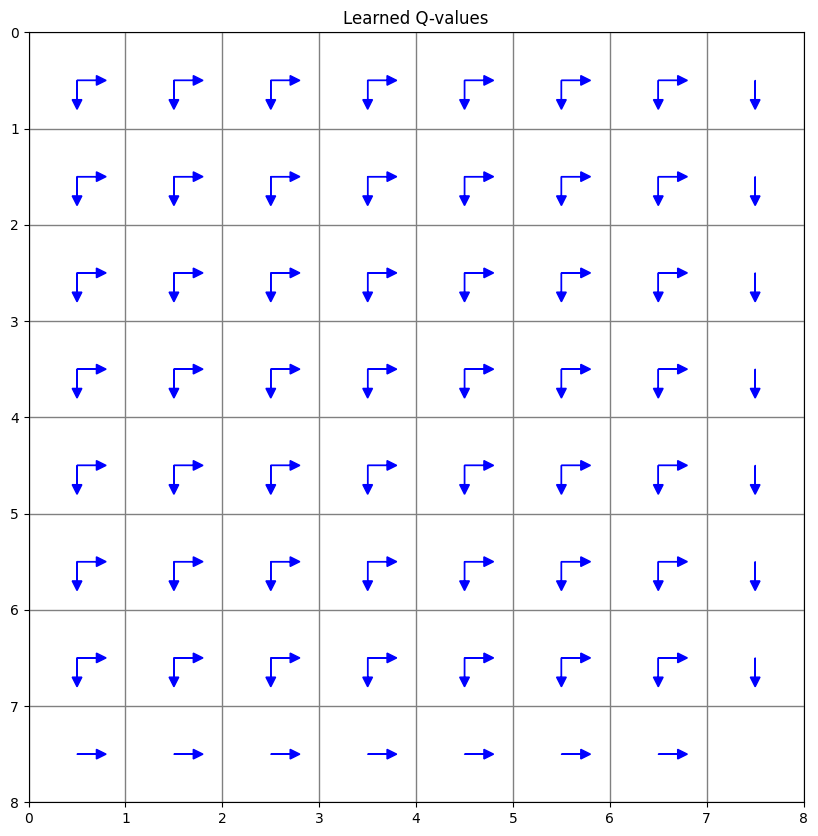

In [63]:
size =8
env_size = (size,size)
rewarded_terminal = env_size[0]*env_size[1]
cue_states = [(size//2)+size]
env = GridEnvRightDownNoSelf(env_size=env_size, 
                             rewarded_terminal = [rewarded_terminal],
                             cue_states=cue_states)
# 2. Create the SARSA agent
#    The environment indicates 2 possible base actions (0 = right, 1 = down).
#    But actual valid actions might be fewer in certain states.
n_states = env.num_unique_states  # This should be 16 + however many "unrewarded" states
max_actions = 2  # "right" and "down" are your base actions
# agent = SarsaAgent(n_states=n_states,
#                     max_actions=max_actions,
#                     alpha=0.1,
#                     gamma=0.99,
#                     epsilon=0.1,
#                     seed=42)

# agent = SarsaLambdaAgent(n_states=n_states,
#                          max_actions=max_actions,
#                          alpha=0.1,
#                          gamma=0.99,
#                          lam=0.5, 
#                          epsilon=0.1,
#                          replacing_traces=True,
#                          seed=42)

agent = NthOrderSarsaAgent(
    n=5,
    max_actions=max_actions,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    seed=42
)

# 3. Train the agent
rewards_history = agent.train(env, n_episodes=1000, verbose=True)

# 4. Analyze results
#    For instance, you might want to look at the average reward over the last 100 episodes
avg_reward_last_100 = np.mean(rewards_history[-100:])
print("Average reward over last 100 episodes:", avg_reward_last_100)

# 5. Use or evaluate the learned policy
#    e.g., run one more episode in "evaluation mode" (reduced epsilon)
agent.epsilon = 0.01
test_reward = agent.run_episode(env)
print("Test episode reward:", test_reward)

plot_q_values(agent, env, title="Learned Q-values")

In [75]:
class POMDPRLAgent:
    def __init__(self, env,
                 learning_rate=0.1,
                 discount_factor=0.99,
                 epsilon=0.1):
        """
        Initialize the agent for the POMDP-like problem:
          - We'll store Q-values in a dict: Q[(pos, visited_cue), action].
        """
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon

        # We know positions in [1..16] for a 4x4 grid,
        # plus some terminal states beyond that. We'll only
        # store Q for the "grid portion" + visited_cue dimension.
        # Because once we are in terminal states, no action is needed.

        # Q is a dictionary: Q[(pos, has_visited_cue), a] = float
        self.Q = {}
        self._init_qtable()

        # We'll track our internal visited_cue via memory (i.e. 'belief')
        self.visited_cue_internally_tracked = False

    def _init_qtable(self):
        # For each position in the grid portion (1..env_size^2) 
        # and for each possible visited_cue = False/True,
        # and for each possible action in {0,1},
        # initialize Q-value to 0.
        all_positions = list(self.env.pos_to_state.values())  # e.g. [1..16]
        for pos in all_positions:
            for vc in [False, True]:
                valid_actions = self.env.valid_actions[pos]
                for a in valid_actions:
                    self.Q[((pos, vc), a)] = 0.0

    def get_state_representation(self, raw_state):
        """
        Convert the environment's 'raw_state' into
        (position, visited_cue_internally_tracked).

        Note: 'raw_state' is the integer from the environment: 1..16 or
        a terminal > 16, etc.

        The agent internally updates 'visited_cue_internally_tracked'.
        """
        # If raw_state is still in the grid (1..16), update the visited_cue_internally_tracked if we see a cue
        if raw_state in self.env.rewarded_terminals + self.env.unrewarded_terminals:
            # It's a terminal state. We can return something
            # but typically we won't pick an action from here.
            # Return a special marker or re-use the same state representation.
            # We'll just note that for Q-learning we won't do updates from terminal -> terminal.
            # We'll do something consistent:
            #    (raw_state, visited_cue_internally_tracked)
            # but it won't matter because no actions are valid from terminal.
            return (raw_state, self.visited_cue_internally_tracked)
        else:
            # It's a valid grid position in 1..16
            # Check if it is a cue. If yes, we set visited_cue_internally_tracked = True
            if raw_state in self.env.cue_states:
                self.visited_cue_internally_tracked = True
            return (raw_state, self.visited_cue_internally_tracked)

    def select_action(self, state):
        """
        Epsilon-greedy policy. 'state' is (pos, visited_cue).
        """
        (pos, vc) = state
        valid_actions = self.env.get_valid_actions(pos)  # 0,1 or empty list
        if len(valid_actions) == 0:
            return None  # terminal

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            # Greedy w.r.t. Q
            qvals = [self.Q.get(((pos, vc), a), 0) for a in valid_actions]
            max_q = max(qvals)
            # tie-break if needed
            best_actions = [a for a, qv in zip(valid_actions, qvals) if qv == max_q]
            return random.choice(best_actions)

    def train(self, num_episodes=500):
        """
        Main Q-learning loop.
        """
        for ep in range(num_episodes):
            # Reset environment, reset internal visited_cue memory
            raw_state = self.env.reset()
            self.visited_cue_internally_tracked = False

            done = False
            while not done:
                # Convert environment state -> internal POMDP-state
                agent_state = self.get_state_representation(raw_state)

                # Pick an action
                action = self.select_action(agent_state)
                if action is None:
                    # Terminal or no valid actions
                    break

                # Step
                next_raw_state, reward, done = self.env.step(action)

                # Next agent state for Q-learning
                next_agent_state = self.get_state_representation(next_raw_state)

                # Q-learning update
                (pos, vc) = agent_state
                # If next state is terminal, the next Q = 0
                if (next_raw_state in self.env.rewarded_terminals + self.env.unrewarded_terminals):
                    q_next_max = 0.0
                else:
                    # Among valid actions from next state
                    (npos, nvc) = next_agent_state
                    next_valid_actions = self.env.get_valid_actions(npos)
                    if len(next_valid_actions) == 0:
                        q_next_max = 0.0
                    else:
                        q_next_vals = [self.Q.get(((npos, nvc), a), 0.0)
                                       for a in next_valid_actions]
                        q_next_max = max(q_next_vals)

                # Current Q
                current_q = self.Q.get(((pos, vc), action), 0.0)
                # TD Target
                td_target = reward + self.gamma * q_next_max
                # Update
                new_q = current_q + self.alpha * (td_target - current_q)
                self.Q[((pos, vc), action)] = new_q

    def get_greedy_action(self, state):
        """
        For evaluation: returns the highest-value action given (pos, visited_cue).
        """
        (pos, vc) = state
        valid_actions = self.env.get_valid_actions(pos)
        if not valid_actions:
            return None
        qvals = [(a, self.Q.get(((pos, vc), a), 0.0)) for a in valid_actions]
        best_a = max(qvals, key=lambda x: x[1])[0]
        return best_a

    def evaluate_policy(self, max_steps=50):
        """
        Evaluate the greedy policy by running a single episode.
        """
        raw_state = self.env.reset()
        self.visited_cue_internally_tracked = False
        done = False
        total_reward = 0
        trajectory = []

        for _ in range(max_steps):
            agent_state = self.get_state_representation(raw_state)
            action = self.get_greedy_action(agent_state)
            trajectory.append((agent_state, action))
            if action is None:
                break
            next_raw_state, reward, done = self.env.step(action)
            total_reward += reward
            raw_state = next_raw_state
            if done:
                break

        return trajectory, total_reward
env = GridEnvRightDownNoSelf(cue_states=[2], env_size=(4,4), rewarded_terminal=[16])

# Create the POMDP agent
agent = POMDPRLAgent(env,
                        learning_rate=0.1,
                        discount_factor=0.99,
                        epsilon=0.1)

# Train
agent.train(num_episodes=1000)

# Evaluate
traj, total_r = agent.evaluate_policy()
print("Final greedy policy episode reward:", total_r)
print("Trajectory (state, action):")
for t in traj:
    print(t)

ValueError: Action 0 is not valid from state 12.

<Axes: >

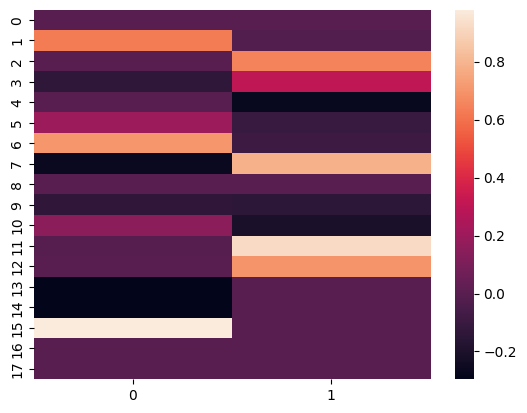

In [18]:
sns.heatmap(agent.Q)